In [1]:
# Dataset: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification/data
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

Dataset URL: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 2.59G/2.59G [01:05<00:00, 44.2MB/s]
100% 2.59G/2.59G [01:05<00:00, 42.5MB/s]


In [2]:
!unzip ham1000-segmentation-and-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: masks/ISIC_0029321_segmentation.png  
  inflating: masks/ISIC_0029322_segmentation.png  
  inflating: masks/ISIC_0029323_segmentation.png  
  inflating: masks/ISIC_0029324_segmentation.png  
  inflating: masks/ISIC_0029325_segmentation.png  
  inflating: masks/ISIC_0029326_segmentation.png  
  inflating: masks/ISIC_0029327_segmentation.png  
  inflating: masks/ISIC_0029328_segmentation.png  
  inflating: masks/ISIC_0029329_segmentation.png  
  inflating: masks/ISIC_0029330_segmentation.png  
  inflating: masks/ISIC_0029331_segmentation.png  
  inflating: masks/ISIC_0029332_segmentation.png  
  inflating: masks/ISIC_0029333_segmentation.png  
  inflating: masks/ISIC_0029334_segmentation.png  
  inflating: masks/ISIC_0029335_segmentation.png  
  inflating: masks/ISIC_0029336_segmentation.png  
  inflating: masks/ISIC_0029337_segmentation.png  
  inflating: masks/ISIC_0029338_segmentation.png  
  inflating: masks/ISIC_0029339

**Segmentation Dataset Reading**

No missing masks found.


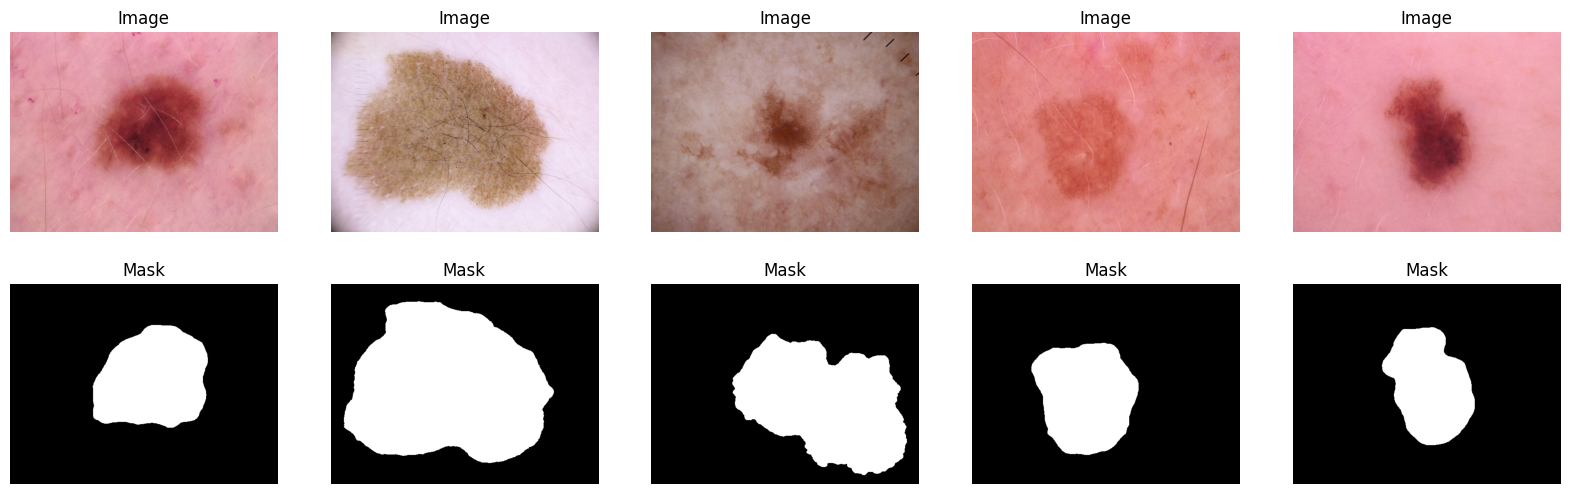

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob as gb
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, add
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
img_dir = "/content/images"
mask_dir = "/content/masks"

img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])
image_names = [os.path.splitext(f)[0] for f in img_files]    # ('ISIC_0024306', '.jpg')
mask_names = [os.path.splitext(f)[0].replace('_segmentation', '') for f in mask_files]    # ('ISIC_0024306_segmentation', 'png')

missing_masks = [f for f in image_names if f not in mask_names]

if len(missing_masks) == 0:
    print('No missing masks found.')
else:
    print(f"There are {len(missing_masks)} missing masks found:")
    print(missing_masks)
def display_image_and_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(2, n, figsize=(20, 6))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(img_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        axs[0, i].imshow(img)
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')

        axs[1, i].imshow(mask,cmap="gray")
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')

plt.show()
display_image_and_mask(n=5, seed=42)

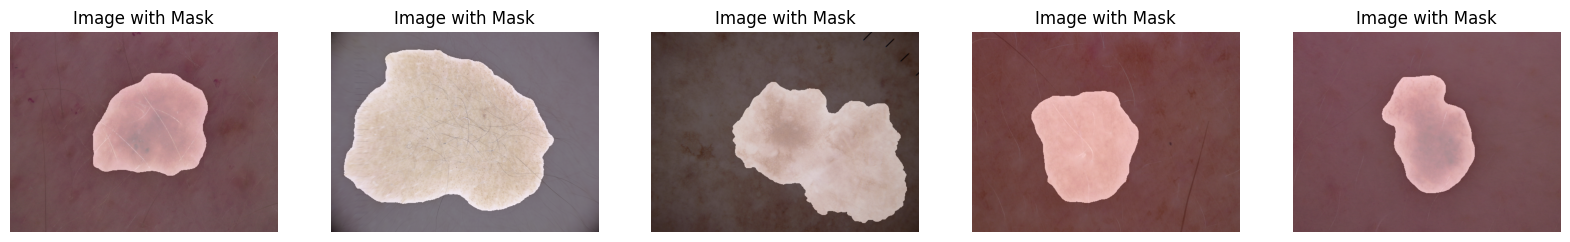

In [15]:
def display_image_with_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(img_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img_np = np.array(Image.open(img_path))
        mask_np = np.array(Image.open(mask_path))

        axs[i].imshow(img_np)
        axs[i].imshow(mask_np, cmap='gray', alpha=0.5)
        axs[i].set_title('Image with Mask')
        axs[i].axis('off')

plt.show()
display_image_with_mask(n=5, seed=42)

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE
def img_mask_paths(img_dir, mask_dir):
    img_path = sorted(gb.glob(os.path.join(img_dir, '*.jpg')))
    mask_path = sorted(gb.glob(os.path.join(mask_dir, '*.png')))
    return np.array(img_path), np.array(mask_path)

imgs_path, masks_path = img_mask_paths(img_dir, mask_dir)
X_train, X_temp, y_train, y_temp = train_test_split(imgs_path, masks_path, train_size=0.90, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)
print(f"{'Training:':<15}{len(X_train)}")
print(f"{'Validation:':<15}{len(X_val)}")
print(f"{'Testing:':<15}{len(X_test)}")
def map_fn(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0
    return img, mask
# train_set
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(map_fn, num_parallel_calls=AUTOTUNE)
train_set = train_set.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# val_set
val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_set = val_set.map(map_fn, num_parallel_calls=AUTOTUNE)
val_set = val_set.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# test_set
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(map_fn, num_parallel_calls=AUTOTUNE)
test_set = test_set.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Training:      9013
Validation:    501
Testing:       501


**Segmentation Model**

In [ ]:
# U-Net Model
def UNET():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = Conv2D(32, 3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    skip_connections = []

    # Encoder
    for filters in [64, 128, 256, 512]:
        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        skip_connections.append(x)
        x = MaxPooling2D(2, strides=2, padding='same')(x)

    # Bottleneck
    x = Conv2D(1024, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1024, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    for filters in [512, 256, 128, 64]:
        x = Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        skip_connection = skip_connections.pop()
        x = add([x, skip_connection])

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    outputs = Conv2D(1, 1, strides=1, activation='sigmoid')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
"""
The Dice coefficient is a measure of the similarity between two sets, A and B. The coefficient ranges from 0 to 1, where 1 indicates that the two sets are identical, and 0 indicates that the two sets have no overlap. It is defined as:
Dice coefficient = 2 * |A ∩ B| / (|A| + |B|)
"""
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)
model = UNET()
model.compile(optimizer=Adam(0.0002),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), dice_coefficient])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 27,939,585 (106.58 MB)

 Trainable params: 27,927,745 (106.54 MB)

 Non-trainable params: 11,840 (46.25 KB)

In [ ]:
checkpoint_cb = ModelCheckpoint('best_weights.weights.h5',
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=5,
                                 verbose=1)
history = model.fit(train_set, epochs=10, validation_data=val_set, callbacks=[checkpoint_cb, reduce_lr_cb])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8862 - dice_coefficient: 0.7029 - loss: 0.2777 - precision: 0.8090 - recall: 0.7831

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.43771, saving model to best_weights.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.8864 - dice_coefficient: 0.7032 - loss: 0.2775 - precision: 0.8092 - recall: 0.7832 - val_accuracy: 0.8490 - val_dice_coefficient: 0.6108 - val_loss: 0.4377 - val_precision: 0.9850 - val_recall: 0.4618 - learning_rate: 2.0000e-04
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9427 - dice_coefficient: 0.8375 - loss: 0.1456 - precision: 0.9176 - recall: 0.8741
Epoch 2: val_loss improved from 0.43771 to 0.13195, saving model to best_weights.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.9427 - dice_coefficient: 0.8375 - loss: 0.1456 - precision: 0.9176 - recall: 0.8741 - val_accuracy: 0.9472 - val_dice_coefficient: 0.8571 - val_loss: 0.1319 - val_precision: 0.9386 - val_recall: 0.8736 - learning_rate: 2.0000e-04
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9465 - dice_coefficient: 0.8539 -

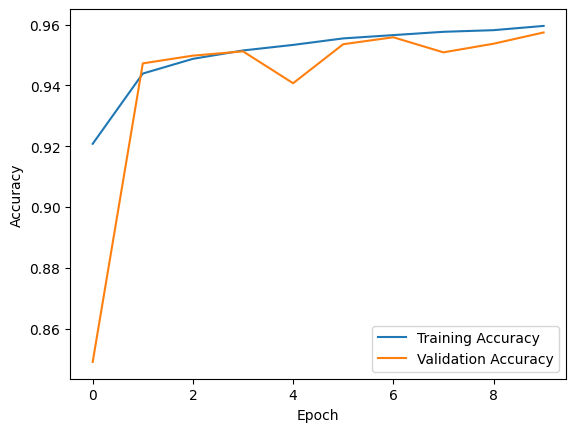

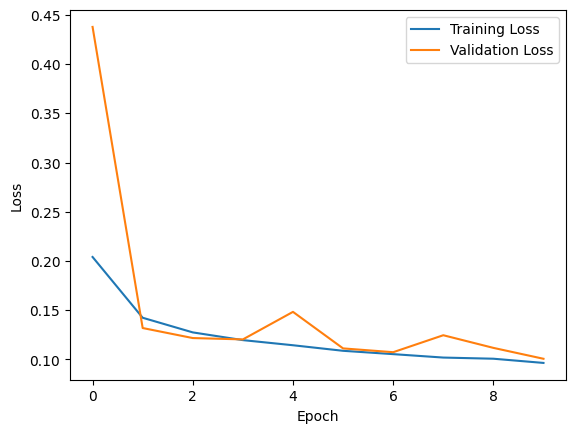

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy, precision, recall, dice_coefficient = model.evaluate(test_set)
print(f"{'Test Loss:':<25}{loss:.4f}")
print(f"{'Test Accuracy:':<25}{accuracy:.4f}")
print(f"{'Test Precision:':<25}{precision:.4f}")
print(f"{'Test Recall:':<25}{recall:.4f}")
print(f"{'Test Dice Coefficient:':<25}{dice_coefficient:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 494ms/step - accuracy: 0.9619 - dice_coefficient: 0.9061 - loss: 0.0952 - precision: 0.9561 - recall: 0.9129
Test Loss:               0.0996
Test Accuracy:           0.9602
Test Precision:          0.9514
Test Recall:             0.9100
Test Dice Coefficient:   0.9023


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


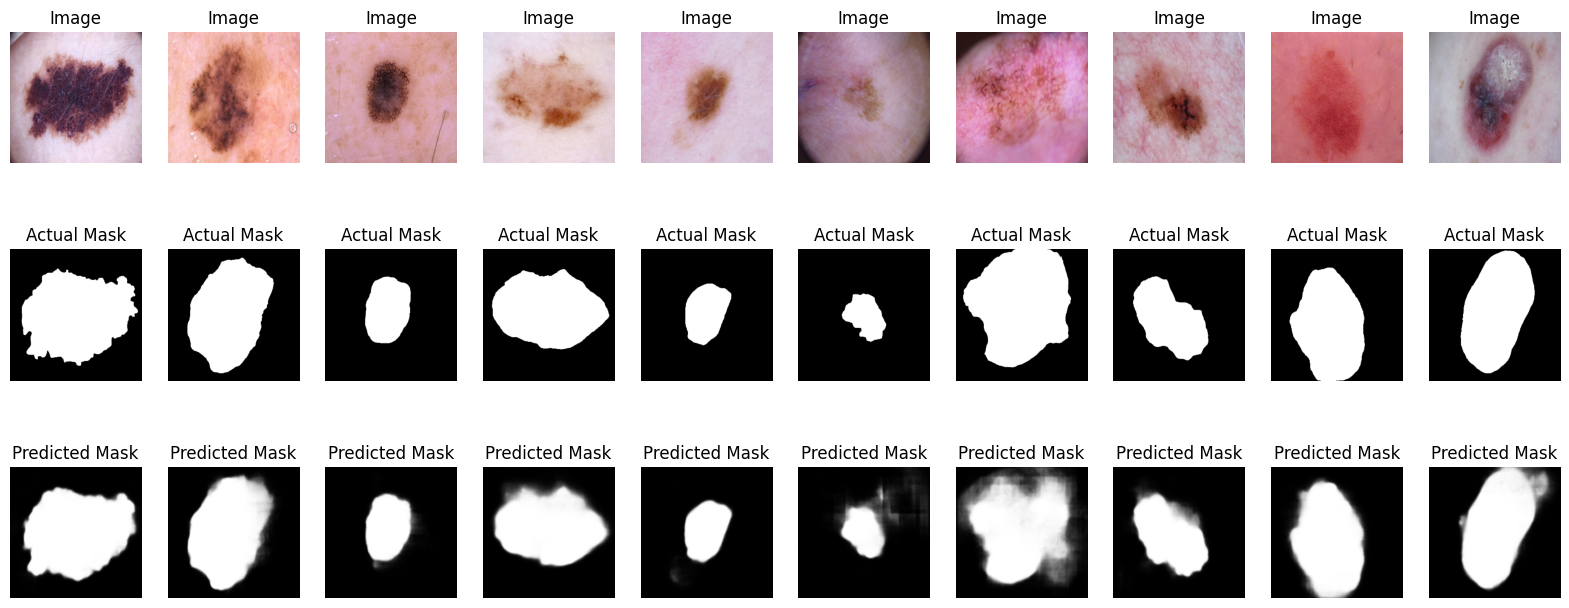

In [ ]:
n_imgs = 10
test_imgs, test_masks = next(iter(test_set))
y_pred = model.predict(test_imgs[:n_imgs], verbose=1)
def display_predictions(n, test_imgs, test_masks, y_pred):
    fig, axs = plt.subplots(3, n, figsize=(20, 8))
    for i in range(n):
        axs[0, i].imshow(test_imgs[i])
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')

        axs[1, i].imshow(test_masks[i],cmap="gray")
        axs[1, i].set_title('Actual Mask')
        axs[1, i].axis('off')

        axs[2, i].imshow(y_pred[i],cmap="gray")
        axs[2, i].set_title(f'Predicted Mask')
        axs[2, i].axis('off')

plt.show()
display_predictions(n=n_imgs,
                    test_imgs=test_imgs[:n_imgs],
                    test_masks=test_masks[:n_imgs],
                    y_pred=y_pred)

**Classification Models**

<ipython-input-1-89e8b73efd0c>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_df = pd.concat([balanced_df, class_sample])


Image Shape: (2584, 224, 224, 3)
Label Shape: (2584, 7)


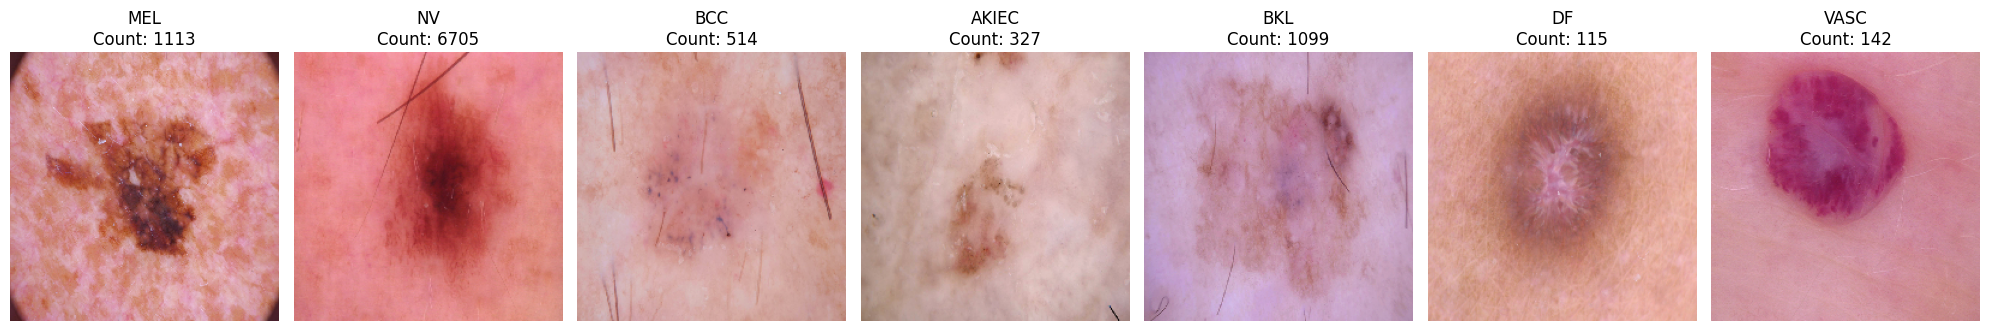

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the CSV file
df = pd.read_csv("/content/GroundTruth.csv")

# Define the image directory
image_folder = "/content/images/"

# Get class names (excluding 'image' column)
class_names = df.columns[1:]

# Create a balanced dataset with 500 images per class
balanced_df = pd.DataFrame(columns=df.columns)
for class_name in class_names:
    # Select images where the class is labeled as 1
    class_df = df[df[class_name] == 1]
    # Randomly sample 500 images if more exist, otherwise take all
    class_sample = class_df.sample(n=min(500, len(class_df)), random_state=42)
    # Append to balanced dataframe
    balanced_df = pd.concat([balanced_df, class_sample])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Function to load images
def load_image_and_label(image_name, label_row):
    img_path = os.path.join(image_folder, image_name + ".jpg")  # Assuming images are .jpg
    image = load_img(img_path, target_size=(224, 224))  # Resize images if needed
    image = img_to_array(image) / 255.0  # Normalize
    label = np.array(label_row, dtype="float32")  # Convert labels to NumPy array
    return image, label

# Load images and labels
image_list = []
label_list = []
for _, row in balanced_df.iterrows():
    image_name = row["image"]
    labels = row.iloc[1:].values  # Extract labels (excluding image name)
    img, lbl = load_image_and_label(image_name, labels)

    image_list.append(img)
    label_list.append(lbl)

# Convert to NumPy arrays
image_array = np.array(image_list)
label_array = np.array(label_list)

# Check dataset shape
print("Image Shape:", image_array.shape)  # (num_samples, 224, 224, 3)
print("Label Shape:", label_array.shape)  # (num_samples, num_classes)

# Initialize figure with 1 row and 7 columns
fig, axes = plt.subplots(1, 7, figsize=(20, 5))

# Loop through each class and display one sample image
for i, class_name in enumerate(class_names):
    # Get all images belonging to this class
    class_df = df[df[class_name] == 1]
    total_count = len(class_df)

    if total_count > 0:
        # Select one sample image
        sample_image_name = class_df.iloc[0]['image']
        img_path = os.path.join(image_folder, sample_image_name + ".jpg")

        # Load and display the image
        image = load_img(img_path, target_size=(224, 224))
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"{class_name}\nCount: {total_count}")
    else:
        axes[i].axis("off")
        axes[i].set_title(f"{class_name}\nCount: 0")

# Show the plot
plt.tight_layout()
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(image_array, label_array, test_size=0.2, stratify=label_array, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2067, 224, 224, 3) (517, 224, 224, 3) (2067, 7) (517, 7)


**VGG19**

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25088)               │         100,352 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │      51,382,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,624,647 (280.86 MB)

 Trainable params: 53,543,943 (204.25 MB)

 Non-trainable params: 20,080,704 (76.60 MB)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 570ms/step - accuracy: 0.3200 - loss: 2.1959 - val_accuracy: 0.3810 - val_loss: 1.6194
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.5129 - loss: 1.3826 - val_accuracy: 0.4217 - val_loss: 1.5628
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.6281 - loss: 1.0709 - val_accuracy: 0.4836 - val_loss: 1.3298
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 288ms/step - accuracy: 0.6827 - loss: 0.8730 - val_accuracy: 0.5010 - val_loss: 1.3580
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.7445 - loss: 0.7129 - val_accuracy: 0.5164 - val_loss: 1.3901
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.7555 - loss: 0.6705 - val_accuracy: 0.5126 - val_loss: 1.4376
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.7774 - loss: 0.6312 - val_accuracy: 0.5493 - val_loss: 1.4691
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 0.7940 - loss: 0.5944 - val_accu

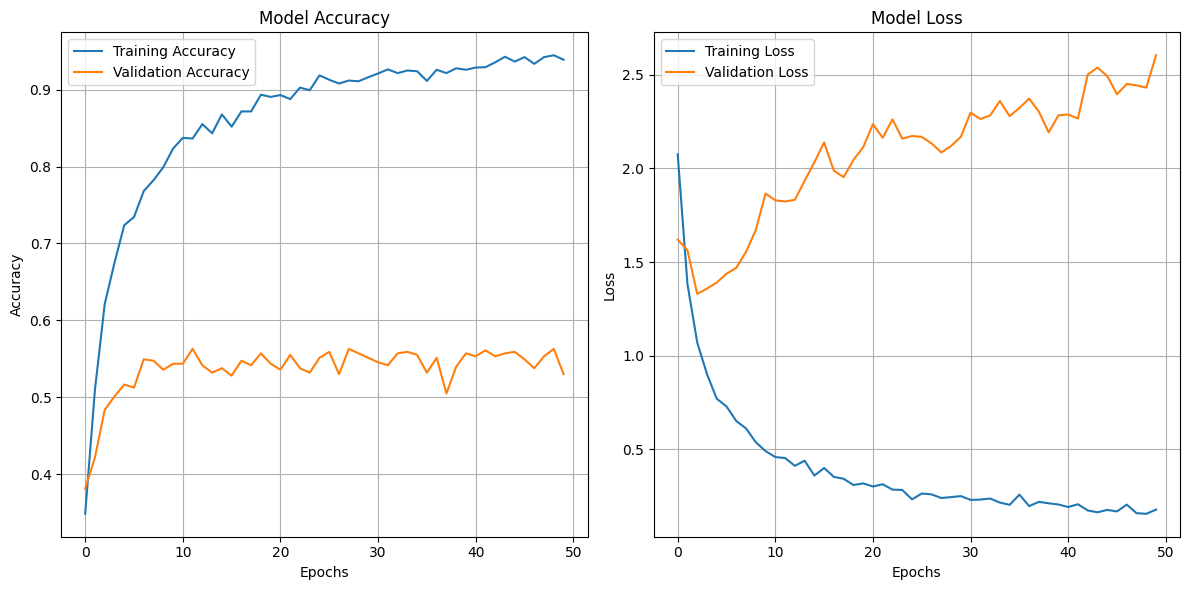

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step


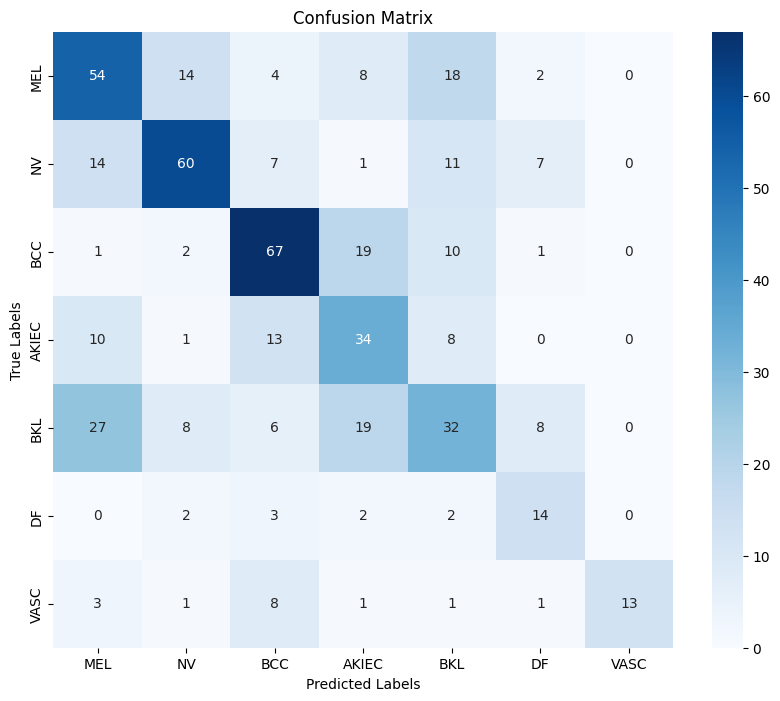

Classification Report:
              precision    recall  f1-score   support

         MEL       0.50      0.54      0.52       100
          NV       0.68      0.60      0.64       100
         BCC       0.62      0.67      0.64       100
       AKIEC       0.40      0.52      0.45        66
         BKL       0.39      0.32      0.35       100
          DF       0.42      0.61      0.50        23
        VASC       1.00      0.46      0.63        28

    accuracy                           0.53       517
   macro avg       0.57      0.53      0.53       517
weighted avg       0.55      0.53      0.53       517



In [ ]:
from keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
base_model = VGG19(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()
#Fit the model
#Fit the model
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=50,batch_size=32)
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
unique_labels=["MEL",	"NV",	"BCC",	"AKIEC",	"BKL",	"DF",	"VASC"]
# Predict on the test set
y_pred = model.predict(X_test, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=unique_labels)
print("Classification Report:")
print(class_report)

**ResNet50**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100352)              │         401,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2048)                │     205,522,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,629,703 (883.60 MB)

 Trainable params: 207,835,143 (792.83 MB)

 Non-trainable params: 23,794,560 (90.77 MB)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 57s 574ms/step - accuracy: 0.2013 - loss: 2.6127 - val_accuracy: 0.2186 - val_loss: 1.9514
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 155ms/step - accuracy: 0.3338 - loss: 1.9557 - val_accuracy: 0.2282 - val_loss: 1.9687
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.3054 - loss: 1.9615 - val_accuracy: 0.2592 - val_loss: 1.8050
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.3483 - loss: 1.7689 - val_accuracy: 0.3482 - val_loss: 1.7121
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.3749 - loss: 1.6694 - val_accuracy: 0.4004 - val_loss: 1.8727
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.4032 - loss: 1.6018 - val_accuracy: 0.4468 - val_loss: 1.6576
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.3970 - loss: 1.6421 - val_accuracy: 0.4178 - val_loss: 1.7311
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.4109 - loss: 1.5642 - val_accu

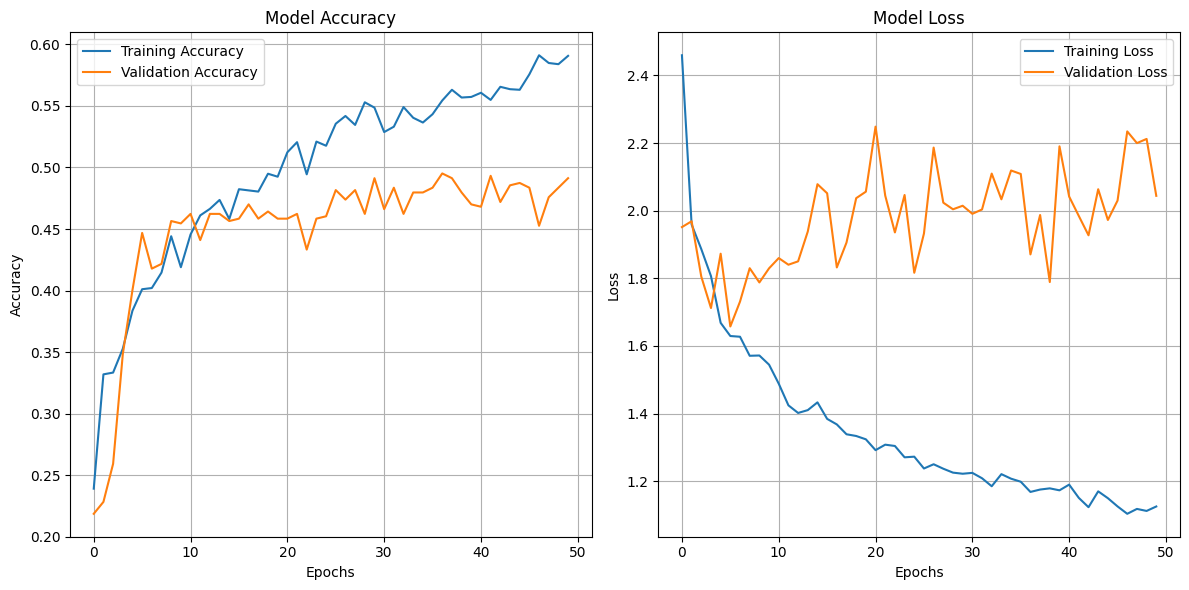

17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step


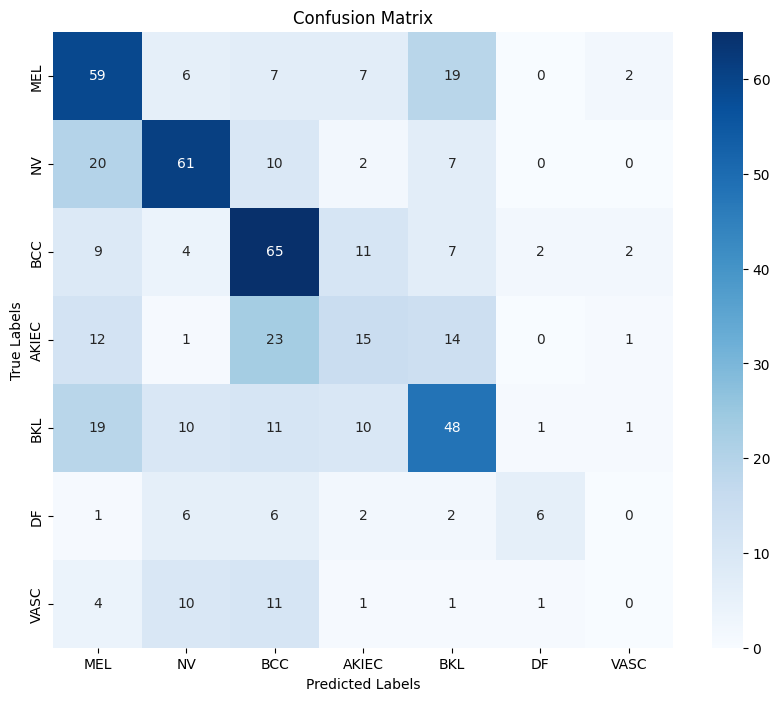

Classification Report:
              precision    recall  f1-score   support

         MEL       0.48      0.59      0.53       100
          NV       0.62      0.61      0.62       100
         BCC       0.49      0.65      0.56       100
       AKIEC       0.31      0.23      0.26        66
         BKL       0.49      0.48      0.48       100
          DF       0.60      0.26      0.36        23
        VASC       0.00      0.00      0.00        28

    accuracy                           0.49       517
   macro avg       0.43      0.40      0.40       517
weighted avg       0.47      0.49      0.47       517



In [ ]:
from keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
base_model = ResNet50(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()
#Fit the model
#Fit the model
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=50,batch_size=32)
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
unique_labels=["MEL",	"NV",	"BCC",	"AKIEC",	"BKL",	"DF",	"VASC"]
# Predict on the test set
y_pred = model.predict(X_test, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=unique_labels)
print("Classification Report:")
print(class_report)

**InceptionV3**

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 5, 5, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 51200)               │         204,800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │     104,859,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_98 (Activation)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_99 (Activation)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,984,871 (492.04 MB)

 Trainable params: 107,073,543 (408.45 MB)

 Non-trainable params: 21,911,328 (83.59 MB)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 593ms/step - accuracy: 0.3259 - loss: 2.1983 - val_accuracy: 0.4526 - val_loss: 3.0099
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.6322 - loss: 1.0718 - val_accuracy: 0.5280 - val_loss: 1.8021
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.7769 - loss: 0.6123 - val_accuracy: 0.5571 - val_loss: 1.5587
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.8653 - loss: 0.4088 - val_accuracy: 0.5590 - val_loss: 1.5264
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.8984 - loss: 0.3025 - val_accuracy: 0.5455 - val_loss: 1.7252
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9267 - loss: 0.2134 - val_accuracy: 0.5609 - val_loss: 1.7605
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.9453 - loss: 0.1676 - val_accuracy: 0.5416 - val_loss: 1.9941
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.9356 - loss: 0.1774 - val_accuracy

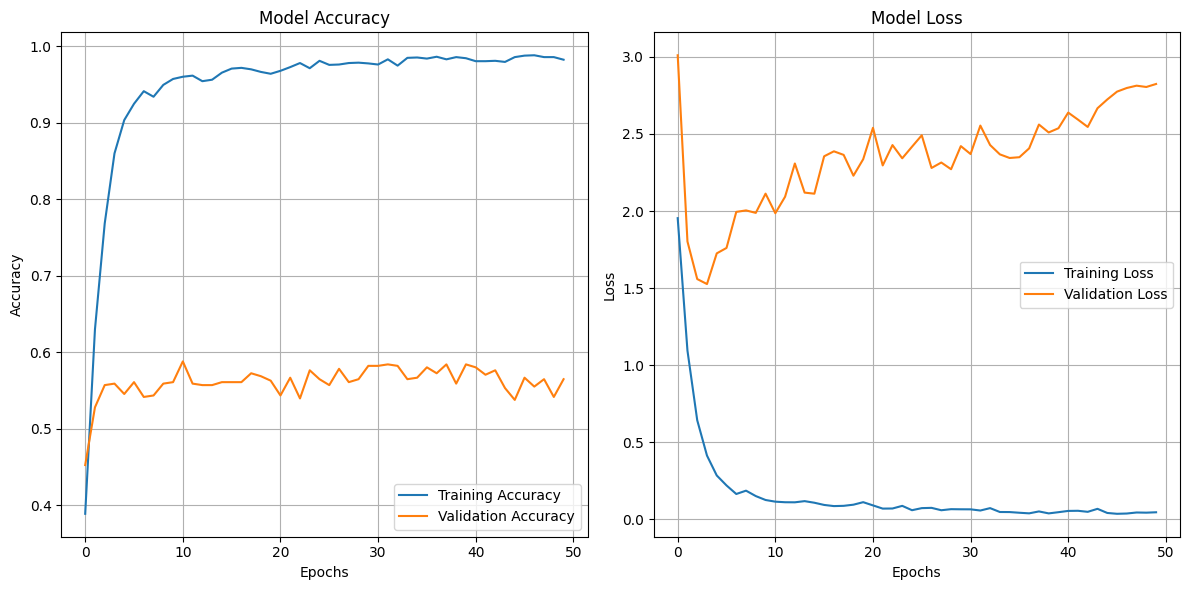

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 521ms/step


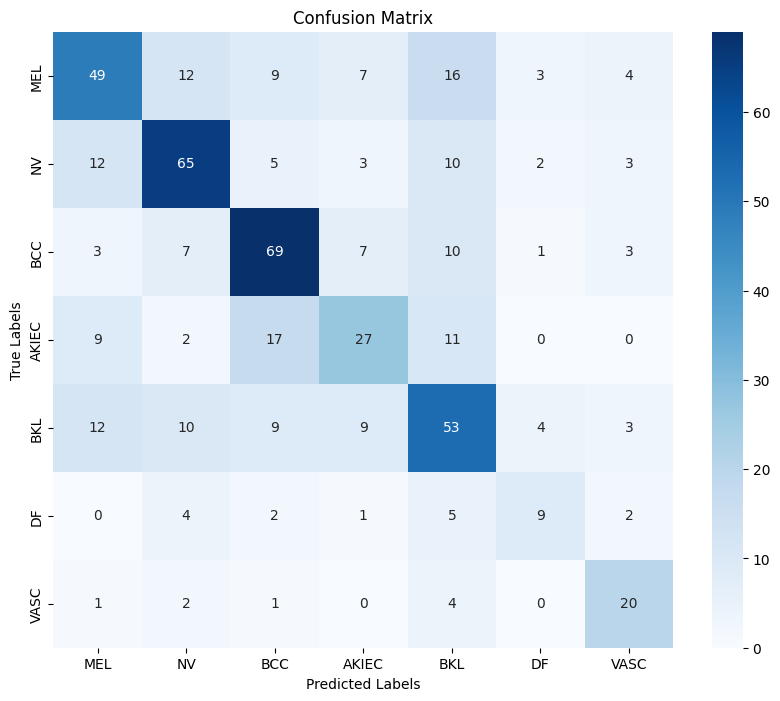

Classification Report:
              precision    recall  f1-score   support

         MEL       0.57      0.49      0.53       100
          NV       0.64      0.65      0.64       100
         BCC       0.62      0.69      0.65       100
       AKIEC       0.50      0.41      0.45        66
         BKL       0.49      0.53      0.51       100
          DF       0.47      0.39      0.43        23
        VASC       0.57      0.71      0.63        28

    accuracy                           0.56       517
   macro avg       0.55      0.55      0.55       517
weighted avg       0.56      0.56      0.56       517



In [ ]:
from keras.models import Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
base_model = InceptionV3(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()
#Fit the model
#Fit the model
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=50,batch_size=32)
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
unique_labels=["MEL",	"NV",	"BCC",	"AKIEC",	"BKL",	"DF",	"VASC"]
# Predict on the test set
y_pred = model.predict(X_test, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=unique_labels)
print("Classification Report:")
print(class_report)

**MobileNetV2**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62720)               │         250,880 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │     128,452,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,079,111 (507.66 MB)

 Trainable params: 130,689,543 (498.54 MB)

 Non-trainable params: 2,389,568 (9.12 MB)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 340ms/step - accuracy: 0.3585 - loss: 2.0253 - val_accuracy: 0.3965 - val_loss: 3.3271
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.6958 - loss: 0.9419 - val_accuracy: 0.5397 - val_loss: 1.8691
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8378 - loss: 0.4836 - val_accuracy: 0.5648 - val_loss: 1.6518
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9081 - loss: 0.2576 - val_accuracy: 0.5938 - val_loss: 1.5202
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9466 - loss: 0.1588 - val_accuracy: 0.5977 - val_loss: 1.7500
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9587 - loss: 0.1317 - val_accuracy: 0.5474 - val_loss: 1.9508
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9579 - loss: 0.1115 - val_accuracy: 0.5648 - val_loss: 1.9568
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9706 - loss: 0.0857 - val_accuracy: 0.545

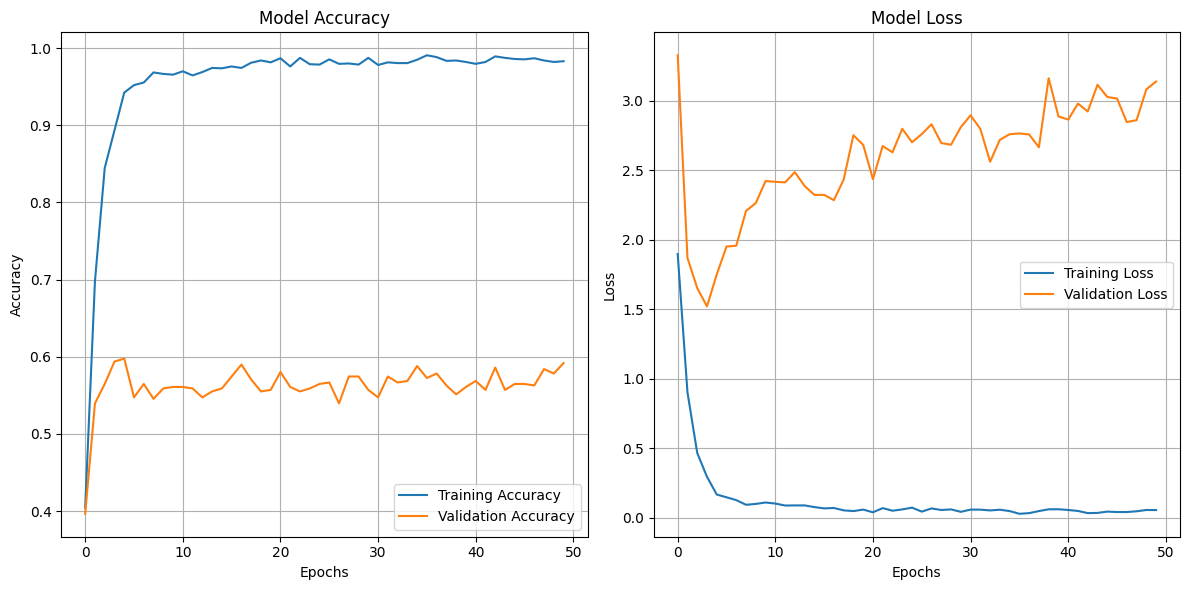

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step


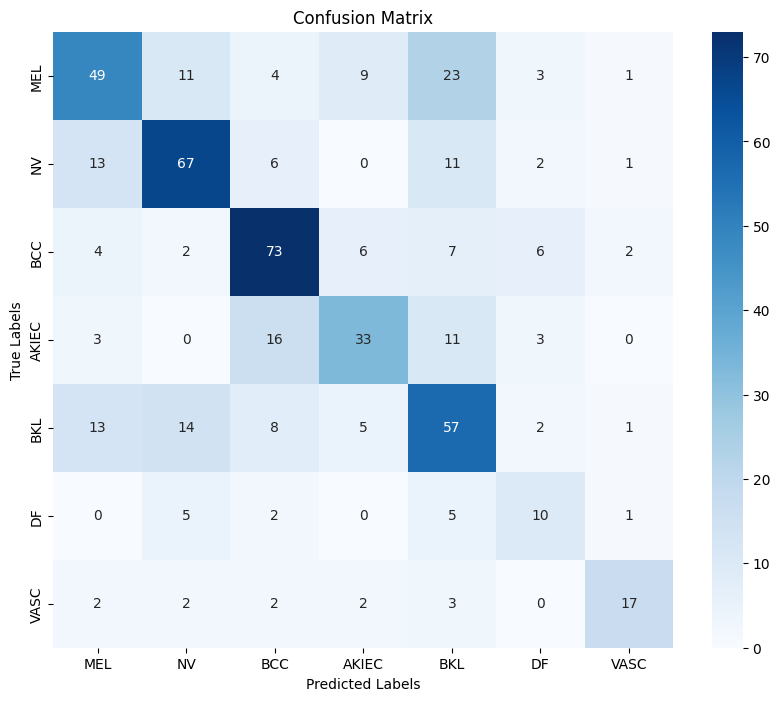

Classification Report:
              precision    recall  f1-score   support

         MEL       0.58      0.49      0.53       100
          NV       0.66      0.67      0.67       100
         BCC       0.66      0.73      0.69       100
       AKIEC       0.60      0.50      0.55        66
         BKL       0.49      0.57      0.53       100
          DF       0.38      0.43      0.41        23
        VASC       0.74      0.61      0.67        28

    accuracy                           0.59       517
   macro avg       0.59      0.57      0.58       517
weighted avg       0.60      0.59      0.59       517



In [ ]:
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
base_model = MobileNetV2(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()
#Fit the model
#Fit the model
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=50,batch_size=32)
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
unique_labels=["MEL",	"NV",	"BCC",	"AKIEC",	"BKL",	"DF",	"VASC"]
# Predict on the test set
y_pred = model.predict(X_test, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=unique_labels)
print("Classification Report:")
print(class_report)

**DenseNet121**

In [ ]:
from keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
base_model = DenseNet121(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()
#Fit the model
#Fit the model
history = model.fit(image_array, label_array, validation_data=(X_test,y_test), epochs=50,batch_size=32)
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
unique_labels=["MEL",	"NV",	"BCC",	"AKIEC",	"BKL",	"DF",	"VASC"]
# Predict on the test set
y_pred = model.predict(X_test, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=unique_labels)
print("Classification Report:")
print(class_report)

**Proposed Lite-CNN**

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 220, 220, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 108, 108, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 106, 106, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 51, 51, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 49, 49, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      37,749,248 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 38,043,687 (145.13 MB)

 Trainable params: 38,041,767 (145.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 244ms/step - accuracy: 0.3971 - loss: 2.1570 - val_accuracy: 0.0542 - val_loss: 4.2961
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.7272 - loss: 0.7982 - val_accuracy: 0.0542 - val_loss: 7.4299
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.8478 - loss: 0.4834 - val_accuracy: 0.0542 - val_loss: 7.3985
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9182 - loss: 0.2761 - val_accuracy: 0.2012 - val_loss: 5.5254
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9541 - loss: 0.1685 - val_accuracy: 0.2940 - val_loss: 3.5873
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9639 - loss: 0.1465 - val_accuracy: 0.5783 - val_loss: 1.3527
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.9704 - loss: 0.1061 - val_accuracy: 0.8259 - val_loss: 0.4603
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9624 - loss: 0.1238 - val_accu

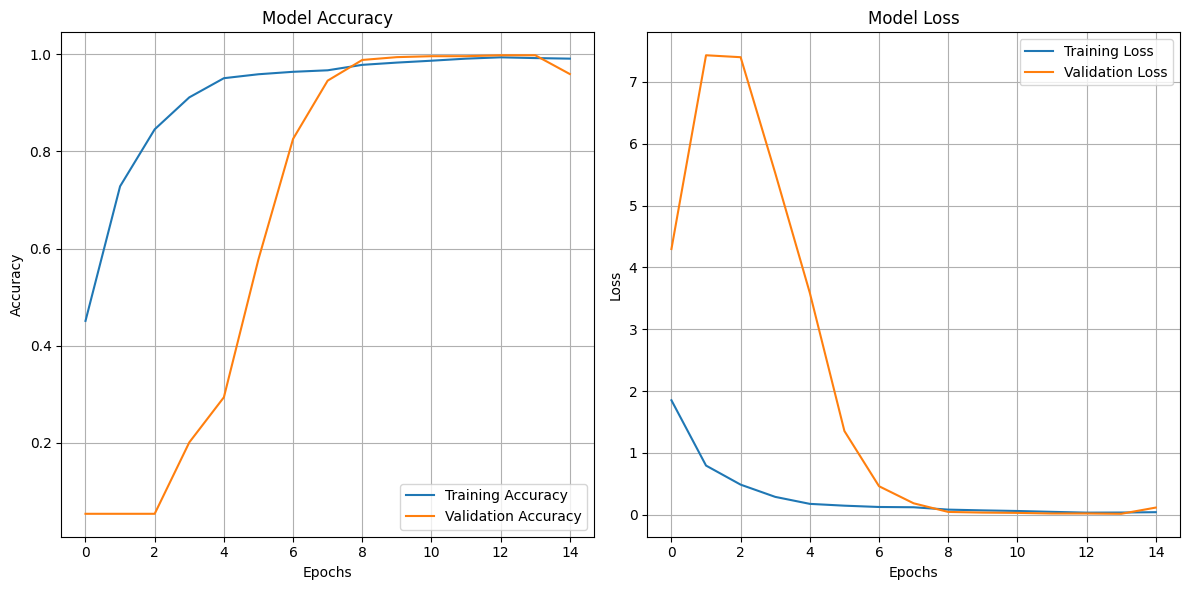

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step


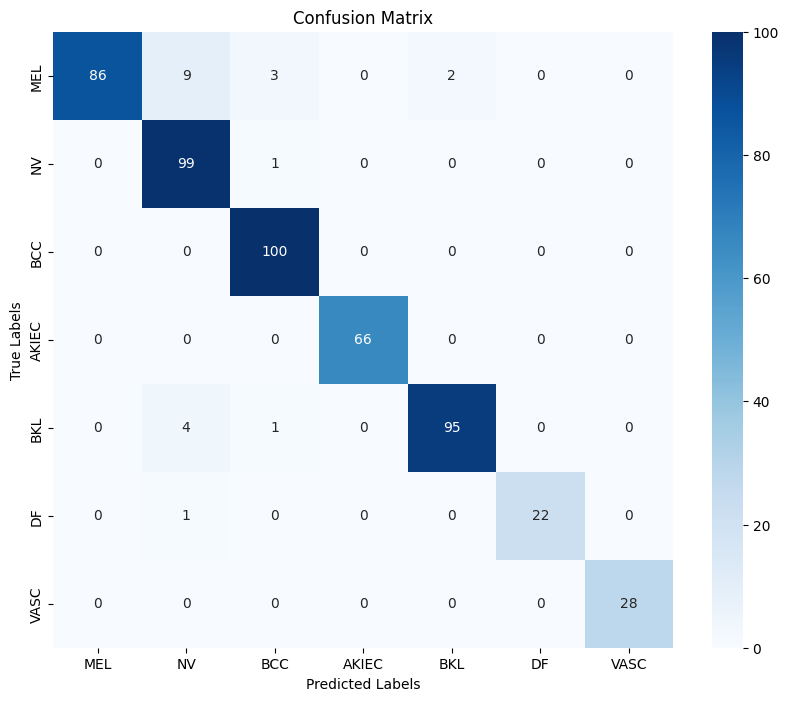

Classification Report:
              precision    recall  f1-score   support

         MEL       1.00      0.86      0.92       100
          NV       0.88      0.99      0.93       100
         BCC       0.95      1.00      0.98       100
       AKIEC       1.00      1.00      1.00        66
         BKL       0.98      0.95      0.96       100
          DF       1.00      0.96      0.98        23
        VASC       1.00      1.00      1.00        28

    accuracy                           0.96       517
   macro avg       0.97      0.97      0.97       517
weighted avg       0.96      0.96      0.96       517



In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
# Define your new model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

#Fit the model
history = model.fit(image_array, label_array, validation_data=(X_test,y_test), epochs=15,batch_size=32)
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
unique_labels=["MEL",	"NV",	"BCC",	"AKIEC",	"BKL",	"DF",	"VASC"]
# Predict on the test set
y_pred = model.predict(X_test, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=unique_labels)
print("Classification Report:")
print(class_report)